<a href="https://colab.research.google.com/github/kmc89/Concrete-Strength-Prediction/blob/master/UCLA_tf.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
#!pip install -q tensorflow-gpu==1.15.0

In [0]:
import numpy as np
import pandas as pd
import math
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('darkgrid')
from sklearn.model_selection import KFold, cross_val_score, train_test_split
from sklearn.preprocessing import StandardScaler, RobustScaler, MinMaxScaler, Normalizer
from sklearn.metrics import mean_squared_error, make_scorer, r2_score
from sklearn.utils import shuffle

import tensorflow as tf
# keras
from tensorflow.keras.layers import Dense, Input, Activation, LeakyReLU
from tensorflow.keras.layers import BatchNormalization, Add, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import Model, load_model
from tensorflow.keras import callbacks
from tensorflow.keras import backend as K
from tensorflow.keras.wrappers.scikit_learn import KerasRegressor
print(tf.__version__)

1.15.0


In [0]:
# import data
from google.colab import files, drive
drive.mount("/content/gdrive")
# files.upload()

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/gdrive


In [0]:
# Code to read csv file into Colaboratory:
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials
# Authenticate and create the PyDrive client.
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

In [0]:
link = "https://drive.google.com/open?id=1niFDtDbD-NtI0fINwxGidgAoVgRI5r1g"
fluff, id_down = link.split('=')
print("File ID: {}".format(id_down))

upload_link = "https://drive.google.com/open?id=1OPkyRvIKKjor9RspmfJ2eP9c02rXNzKV"
url, id_up = link.split('=')
print("Upload folder ID: {}".format(id_up))

file = drive.CreateFile({'id':id_down}) 
file.GetContentFile('clean_data_28days.csv')

File ID: 1niFDtDbD-NtI0fINwxGidgAoVgRI5r1g
Upload folder ID: 1niFDtDbD-NtI0fINwxGidgAoVgRI5r1g


In [0]:
df_data = pd.read_csv('clean_data_28days.csv')
df_data.describe()

,AEA Dose (oz/cwt),TYPE AWRA Dose (oz/cwt),W/(C+P),7 Day,28 Day,Coarse Agg Percentage,Fine Agg Percentage,%Fly Ash
count,7441.000000,7441.000000,7441.000000,7441.000000,7441.000000,7441.000000,7441.000000,7441.000000
mean,0.451765,3.298768,0.381364,4356.616046,5776.655019,47.554086,34.968076,3.010362
std,0.282533,1.884618,0.043183,977.603430,1032.851117,1.473127,2.249621,1.753022
min,0.000000,0.000000,0.240000,1720.000000,3200.000000,31.480118,25.965329,0.000000
25%,0.350000,2.010000,0.350000,3740.000000,5080.000000,47.001076,33.337954,1.738581
50%,0.460000,3.990000,0.380000,4200.000000,5640.000000,47.877294,34.767074,3.358313
75%,0.580000,4.920000,0.400000,4830.000000,6340.000000,48.413908,36.413717,3.703186
max,3.770000,6.080000,0.590000,35790.000000,12050.000000,54.070968,52.551303,6.511770


In [0]:
df_data.columns

Index(['AEA Dose (oz/cwt)', 'TYPE AWRA Dose (oz/cwt)', 'W/(C+P)', '7 Day',
       '28 Day', 'Coarse Agg Percentage', 'Fine Agg Percentage', '%Fly Ash'],
      dtype='object')

In [0]:
y7 = df_data['7 Day']
y28 = df_data['28 Day']
X = df_data.drop(['7 Day', '28 Day'], axis=1)

X7_train, X7_test, y7_train, y7_test = train_test_split(X, y7, test_size=0.2, random_state=42)
X28_train, X28_test, y28_train, y28_test = train_test_split(X, y28, test_size=0.2, random_state=42)

In [0]:
def plot_history(history, label):
    fig = plt.figure()
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('Loss for %s' % label)
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    _= plt.legend(['Train','Validation'], loc='upper left')
    # plt.savefig(fig, format = "png")
    plt.show()
    # return fig

def upload_image(image, name, upload_folder_id):
    file_name = test_name + ".png"
    file_image = drive.CreateFile({"title": file_name, "mimeType": "png", "parents":  [{"kind": "drive#fileLink","id": upload_folder_id}]})
    file_image.SetContentFile(image) #Set the content to the taken image
    file_image.Upload()

def std(nums):
    Sum = sum(nums)
    dev = 0
    for num in nums:
      dev = (num - Sum)**2
    return math.sqrt(dev/(len(nums)-1))
    

In [0]:
# kreas functions
def root_mean_squared_error(y_true, y_pred):
        return K.sqrt(K.mean(K.square(y_pred - y_true)))

def r2_keras(y_true, y_pred):
    SS_res =  K.sum(K.square(y_true - y_pred)) 
    SS_tot = K.sum(K.square(y_true - K.mean(y_true)))
    return ( 1 - SS_res/(SS_tot + K.epsilon()) )

In [0]:
# nn_model
test_name = "tanh_4l_16-32-32-16"

class build_model:
    def create_nn_model(self, input_shape):
        inp = Input(shape=(input_shape,))

        x = Dense(16)(inp)
        x = BatchNormalization()(x)
        x = Activation("tanh")(x)
        # x = Dropout(0.4)(x)

        x = Dense(32)(x)
        x = BatchNormalization()(x)
        x = Activation("tanh")(x)
        # x = Dropout(0.2)(x)

        x = Dense(32)(x)
        x = BatchNormalization()(x)
        x = Activation("tanh")(x)
        # # x = Dropout(0.4)(x)

        x = Dense(16)(x)
        x = BatchNormalization()(x)
        x = Activation("tanh")(x)
        # x = Dropout(0.4)(x)

        # x = Dense(8)(x)
        # x = BatchNormalization()(x)
        # x = Activation("tanh")(x)
        # x = LeakyReLU(alpha=0.05)(x)
        # x = Dropout(0.4)(x)

        # x = Dense(256)(x)
        # x = BatchNormalization()(x)
        # x = Activation("tanh")(x)
        # # x = LeakyReLU(alpha=0.05)(x)
        # # x = Dropout(0.4)(x)

        # x = Dense(64)(x)
        # x = BatchNormalization()(x)
        # x = Activation("tanh")(x)
        # # x = LeakyReLU(alpha=0.05)(x)
        # # x = Dropout(0.2)(x)

        # x = Dense(32)(x)
        # x = BatchNormalization()(x)
        # x = Activation("tanh")(x)
        # # x = LeakyReLU(alpha=0.05)(x)

        # x = Dense(16)(x)
        # x = BatchNormalization()(x)
        # x = Activation("tanh")(x)
        # x = LeakyReLU(alpha=0.05)(x)
        # x = Dropout(0.2)(x)

        out = Dense(1, activation="linear")(x)# 28 days    
        model = Model(inputs= inp, outputs= out)
        return model

In [0]:
# execute
execute = False;
text_file_name = "20191114.txt"
retrain_times = ""

from datetime import datetime

cv_score=[]
cv_score_total=0
epoch_n = 10000
verbose = 0
batch_size = 128


loss_function = 'mean_squared_error'
# loss_function = root_mean_squared_error
    
# Set to True if we want to train from scratch.  False will reuse saved models as a starting point.
retrain = True

# Set up GPU preferences
config = tf.ConfigProto( device_count = {'GPU': 1 , 'CPU': 2} ) 
config.gpu_options.allow_growth = True
config.gpu_options.per_process_gpu_memory_fraction = 0.6
sess = tf.Session(config=config) 
K.set_session(sess)

start_time=datetime.now()

# Loop through each molecule type
!mkdir -p ~/kaggle/UCLA
model_name_rd = ('/root/kaggle/UCLA/concrete_model.hdf5')
model_name_wrt = ('/root/kaggle/UCLA/concrete_model.hdf5')

# drive.mount("/content/gdrive")
# model_name_rd = ('/content/gdrive/My Drive/Saved Models/UCLA/ucla_concrete.hdf5')
# model_name_wrt = ('/content/gdrive/My Drive/Saved Models/UCLA/ucla_concrete.hdf5')


# Here's our best features.
input_features=['AEA Dose (oz/cwt)', 'TYPE AWRA Dose (oz/cwt)', 'W/(C+P)',
                'Coarse Agg Percentage', 'Fine Agg Percentage', '%Fly Ash'
                ]

df_data = shuffle(df_data, random_state = 42)

# Standard Scaler from sklearn does seem to work better here than other Scalers
input_scaler = StandardScaler() # MinMaxScaler() # RobustScaler()
input_data=input_scaler.fit_transform(df_data[input_features])

y7_data=df_data[["7 Day"]]
y28_data=df_data[["28 Day"]]

#following parameters should be adjusted to control the loss function
#if all parameters are zero, attractors do not work. (-> simple neural network)
m1=1
m2=4
m3=1
target_data=y28_data
target_data_1=y7_data
target_data=StandardScaler().fit_transform(target_data)
target_data_1=m1*(StandardScaler().fit_transform(target_data_1))

# Simple split to provide us a validation set to do our CV checks with
train_index, cv_index = train_test_split(np.arange(len(df_data)), random_state= 42, test_size=0.2)

# Split all our input and targets by train and cv indexes
train_input=input_data[train_index]
cv_input=input_data[cv_index]

train_target=target_data[train_index]
cv_target=target_data[cv_index]

train_target_1=target_data_1[train_index]
cv_target_1=target_data_1[cv_index]

## test_input=input_data[len(train_):,:]

train_target=target_data[train_index]
cv_target=target_data[cv_index]

# Build the Neural Net
new_model = build_model()
nn_model=new_model.create_nn_model(train_input.shape[1])

if execute:

  # If retrain==False, then we load a previous saved model as a starting point.
  if not retrain:
      nn_model = load_model(model_name_rd)
      
  # compile
  #nn_model.compile(loss=loss_function, optimizer=Adam())#, metrics='rmse')
  nn_model.compile(optimizer = "rmsprop", loss = loss_function, metrics =["accuracy"])

  # Callback for Early Stopping... May want to raise the min_delta for small numbers of epochs
  es = callbacks.EarlyStopping(monitor='val_loss', min_delta=0.0000001, patience=8,verbose=1, mode='auto', restore_best_weights=True)
  # Callback for Reducing the Learning Rate... when the monitor levels out for 'patience' epochs, then the LR is reduced
  rlr = callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=7, min_lr=1e-6, mode='auto', verbose=1)
  # Save the best value of the model for future use
  sv_mod = callbacks.ModelCheckpoint(model_name_wrt, monitor='val_loss', save_best_only=True, period=1)

  history = nn_model.fit(train_input,train_target, 
          validation_data=(cv_input,cv_target), 
          callbacks=[es, rlr, sv_mod], epochs=epoch_n, batch_size=batch_size, verbose=verbose)

  # No early stopping
  # history = nn_model.fit(train_input,train_target,
  #         validation_data=(cv_input,cv_target), 
  #         callbacks=[rlr, sv_mod], epochs=epoch_n, batch_size=batch_size, verbose=verbose)

  cv_predict=nn_model.predict(cv_input)
  train_predict=nn_model.predict(train_input)
  plot_history(history,"Concrete")

  accuracy=np.sqrt(np.mean(np.abs(np.square(cv_target)-np.square(cv_predict[:,0]))))
  cv_score.append(accuracy)
  cv_score_total+=accuracy

  end_time=datetime.now()
  '''
  # Predict on the test data set using our trained model
  test_predict=nn_model.predict(test_input)

  # for each molecule type we'll grab the predicted values
  test_prediction[test["type"]==mol_type]=test_predict[0][:,0]
  K.clear_session()
  '''
  ####
  #cv_score_total/=len(mol_types)


  # upload_image(image, test_name, id_up)

  processing_time = end_time - start_time
  # validation
  r2_v = r2_score(cv_target, cv_predict)
  mse_v = mean_squared_error(cv_target, cv_predict)
  rmse_v = math.sqrt(mse_v)
  # Training
  r2_t = r2_score(train_target, train_predict)
  mse_t = mean_squared_error(train_target, train_predict)
  rmse_t = math.sqrt(mse_t)

  record =["Test: {}".format(test_name+retrain_times),
          "Recording time: {}".format(datetime.now()),
          "Duriation: {}".format(processing_time),
          "-------------------------",
          "cv_r2: {}".format(r2_v),
          "cv_mse: {}".format(mse_v),
          "cv_rmse: {}".format(rmse_v),
          "-------------------------",
          "train_r2: {}".format(r2_t),
          "train_mse: {}".format(mse_t),
          "train_rmse: {}".format(rmse_t),
          ]

  with open(r"/content/gdrive/My Drive/UCLA/_Lab/results/"+text_file_name, "a+") as file:
    for line in record:
      file.write(line + "\n")
      print(line)
    file.write("\n")


Instructions for updating:
If using Keras pass *_constraint arguments to layers.


In [0]:
report_again = False
if report_again:
  text_file_name = "20191114.txt"
  retrain_times = ""

  # upload_image(image, test_name, id_up)

  processing_time = end_time - start_time
  # validation
  r2_v = r2_score(cv_target, cv_predict)
  mse_v = mean_squared_error(cv_target, cv_predict)
  rmse_v = math.sqrt(mse_v)
  # Training
  r2_t = r2_score(train_target, train_predict)
  mse_t = mean_squared_error(train_target, train_predict)
  rmse_t = math.sqrt(mse_t)

  record =["Test: {}".format(test_name+retrain_times),
          "Recording time: {}".format(datetime.now()),
          "Duriation: {}".format(processing_time),
          "-------------------------",
          "cv_r2: {}".format(r2_v),
          "cv_mse: {}".format(mse_v),
          "cv_rmse: {}".format(rmse_v),
          "-------------------------",
          "train_r2: {}".format(r2_t),
          "train_mse: {}".format(mse_t),
          "train_rmse: {}".format(rmse_t),
          ]

  with open(r"/content/gdrive/My Drive/UCLA/_Lab/results/"+text_file_name, "a+") as file:
    for line in record:
      file.write(line + "\n")
      print(line)
    file.write("\n")

In [0]:
# Cross Validation
cross_validation = False
# Set to True if we want to train from scratch.  False will reuse saved models as a starting point.
retrain = True
from datetime import datetime

cv_score=[]
cv_score_total=0
epoch_n = 10000
verbose = 0
batch_size = 128

loss_function = 'mean_squared_error'

# Loop through each molecule type
!mkdir -p ~/kaggle/UCLA
model_name_rd = ('/root/kaggle/UCLA/concrete_model.hdf5')
model_name_wrt = ('/root/kaggle/UCLA/concrete_model.hdf5')

Kfold = KFold(n_splits=5, random_state=42, shuffle=True)
# If cv sets to True, applying cv training
if cross_validation:
  start_time=datetime.now()
  cv_no = 0
  rmse_s = []
  r2_s = []

  for train_index, cv_index in Kfold.split(np.arange(len(df_data))):
    cv_no += 1

    train_input=input_data[train_index]
    cv_input=input_data[cv_index]

    train_target=target_data[train_index]
    cv_target=target_data[cv_index]

    # Build the Neural Net
    new_model = build_model()
    nn_model=new_model.create_nn_model(train_input.shape[1])

    # If retrain==False, then we load a previous saved model as a starting point.
    if not retrain:
        nn_model = load_model(model_name_rd)
        
    # If retrain==False, then we load a previous saved model as a starting point.
    if not retrain:
        nn_model = load_model(model_name_rd)
    # compile
    #nn_model.compile(loss=loss_function, optimizer=Adam())#, metrics='rmse')
    nn_model.compile(optimizer = "rmsprop", loss = loss_function, metrics =["accuracy"])

    # Callback for Early Stopping... May want to raise the min_delta for small numbers of epochs
    es = callbacks.EarlyStopping(monitor='val_loss', min_delta=0.0000001, patience=8,verbose=1, mode='auto', restore_best_weights=True)
    # Callback for Reducing the Learning Rate... when the monitor levels out for 'patience' epochs, then the LR is reduced
    rlr = callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=7, min_lr=1e-6, mode='auto', verbose=1)
    # Save the best value of the model for future use
    sv_mod = callbacks.ModelCheckpoint(model_name_wrt, monitor='val_loss', save_best_only=True, period=1)

    history = nn_model.fit(train_input,train_target, 
            validation_data=(cv_input,cv_target), 
            callbacks=[es, rlr, sv_mod], epochs=epoch_n, batch_size=batch_size, verbose=verbose)
    
    cv_predict=nn_model.predict(cv_input)
    train_predict=nn_model.predict(train_input)
    plot_history(history,"Concrete %s" %cv_no)

    end_time=datetime.now()
    processing_time = end_time - start_time
    # validation
    r2_v = r2_score(cv_target, cv_predict)
    mse_v = mean_squared_error(cv_target, cv_predict)
    rmse_v = math.sqrt(mse_v)
    # Training
    r2_t = r2_score(train_target, train_predict)
    mse_t = mean_squared_error(train_target, train_predict)
    rmse_t = math.sqrt(mse_t)

    record =["Test: {}".format(test_name+retrain_times),
            "Recording time: {}".format(datetime.now()),
            "Duriation: {}".format(processing_time),
            "-------------------------",
            "cv_r2: {}".format(r2_v),
            "cv_mse: {}".format(mse_v),
            "cv_rmse: {}".format(rmse_v),
            "-------------------------",
            "train_r2: {}".format(r2_t),
            "train_mse: {}".format(mse_t),
            "train_rmse: {}".format(rmse_t),
            ]
    for line in record:
      # file.write(line + "\n")
      print(line)
    print('\n')
    r2_s.append(r2_v)
    rmse_s.append(rmse_v)

    retrain = False

  print("R2 (cross validation): {}".format(sum(r2_s)/cv_no))
  print("RMSE (cross validation): {}".format(sum(rmse_s)/cv_no))

In [0]:
# nn_model
num_of_layers = "1l"

class build_model:
    def create_nn_model(self, input_shape, num_of_nodes):
        inp = Input(shape=(input_shape,))

        x = Dense(num_of_nodes)(inp)
        x = BatchNormalization()(x)
        x = Activation("tanh")(x)
        # x = Dropout(0.4)(x)

        # x = Dense(num_of_nodes)(x)
        # x = BatchNormalization()(x)
        # x = Activation("tanh")(x)
        # # x = Dropout(0.4)(x)

        # x = Dense(num_of_nodes)(x)
        # x = BatchNormalization()(x)
        # x = Activation("tanh")(x)
        # # x = Dropout(0.4)(x)

        # x = Dense(num_of_nodes)(x)
        # x = BatchNormalization()(x)
        # x = Activation("tanh")(x)
        # # x = Dropout(0.4)(x)

        # x = Dense(num_of_nodes)(x)
        # x = BatchNormalization()(x)
        # x = Activation("tanh")(x)
        # # x = Dropout(0.4)(x)

        # x = Dense(num_of_nodes)(x)
        # x = BatchNormalization()(x)
        # x = Activation("tanh")(x)
        # # x = Dropout(0.4)(x)

        out = Dense(1, activation="linear")(x)# 28 days    
        model = Model(inputs= inp, outputs= out)
        return model


Epoch 00059: ReduceLROnPlateau reducing learning rate to 0.00010000000474974513.
Restoring model weights from the end of the best epoch.
Epoch 00060: early stopping


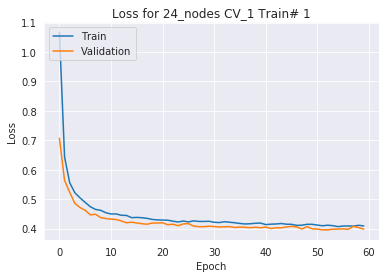

Test: tanh_1l_24
Recording time: 2019-12-11 08:04:41.858561
Duriation: 0:00:15.264600
-------------------------
cv_r2: 0.6067996282896009
cv_mse: 0.395467075894891
cv_rmse: 0.6288617303468951
-------------------------
train_r2: 0.5940273793929078
train_mse: 0.40534183321190637
train_rmse: 0.6366646159571823



Epoch 00076: ReduceLROnPlateau reducing learning rate to 0.00010000000474974513.
Restoring model weights from the end of the best epoch.
Epoch 00077: early stopping


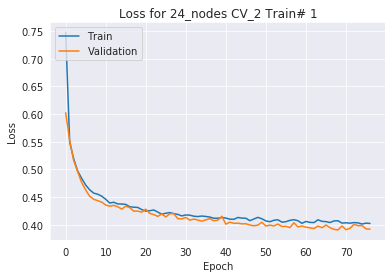

Test: tanh_1l_24
Recording time: 2019-12-11 08:04:58.164925
Duriation: 0:00:31.570525
-------------------------
cv_r2: 0.6034409066712678
cv_mse: 0.3906287596463218
cv_rmse: 0.6250030077098204
-------------------------
train_r2: 0.6064812268461417
train_mse: 0.39497812698650814
train_rmse: 0.6284728530227126



Epoch 00069: ReduceLROnPlateau reducing learning rate to 0.00010000000474974513.
Restoring model weights from the end of the best epoch.
Epoch 00070: early stopping


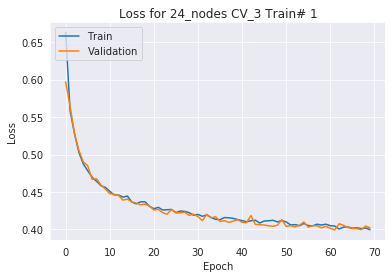

Test: tanh_1l_24
Recording time: 2019-12-11 08:05:12.882503
Duriation: 0:00:46.288169
-------------------------
cv_r2: 0.6067521391048551
cv_mse: 0.3993073123109008
cv_rmse: 0.6319076770469724
-------------------------
train_r2: 0.6024460466003145
train_mse: 0.3960225207331968
train_rmse: 0.629303202544844



Epoch 00078: ReduceLROnPlateau reducing learning rate to 0.00010000000474974513.

Epoch 00103: ReduceLROnPlateau reducing learning rate to 1.0000000474974514e-05.
Restoring model weights from the end of the best epoch.

Epoch 00110: ReduceLROnPlateau reducing learning rate to 1.0000000656873453e-06.
Epoch 00110: early stopping


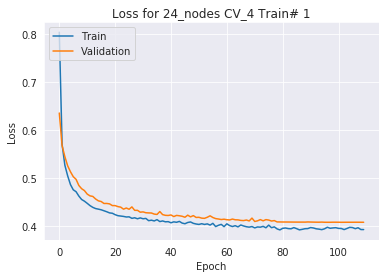

Test: tanh_1l_24
Recording time: 2019-12-11 08:05:34.390707
Duriation: 0:01:07.797068
-------------------------
cv_r2: 0.5924440804529623
cv_mse: 0.40703195286877897
cv_rmse: 0.6379905586047327
-------------------------
train_r2: 0.6141641183403184
train_mse: 0.38595890237436087
train_rmse: 0.6212559073154644



Epoch 00061: ReduceLROnPlateau reducing learning rate to 0.00010000000474974513.
Restoring model weights from the end of the best epoch.
Epoch 00062: early stopping


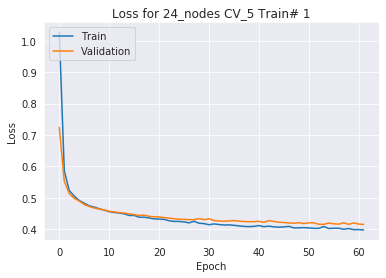

Test: tanh_1l_24
Recording time: 2019-12-11 08:05:47.931917
Duriation: 0:01:21.330628
-------------------------
cv_r2: 0.5823174842728162
cv_mse: 0.41504983123822153
cv_rmse: 0.6442436117170441
-------------------------
train_r2: 0.605875971863441
train_mse: 0.3946336210923505
train_rmse: 0.6281987114698266


Training # 1
R2 (cross validation): 0.5983508477583005
RMSE (cross validation): 0.6336013170850928



Epoch 00056: ReduceLROnPlateau reducing learning rate to 0.00010000000474974513.

Epoch 00066: ReduceLROnPlateau reducing learning rate to 1.0000000474974514e-05.
Restoring model weights from the end of the best epoch.
Epoch 00067: early stopping


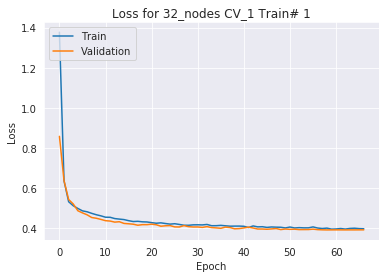

Test: tanh_1l_32
Recording time: 2019-12-11 08:06:02.510402
Duriation: 0:01:35.916328
-------------------------
cv_r2: 0.6108857739363713
cv_mse: 0.39135737461566866
cv_rmse: 0.6255856253269161
-------------------------
train_r2: 0.6087183591726213
train_mse: 0.3906736798111101
train_rmse: 0.625038942635665



Epoch 00049: ReduceLROnPlateau reducing learning rate to 0.00010000000474974513.
Restoring model weights from the end of the best epoch.
Epoch 00050: early stopping


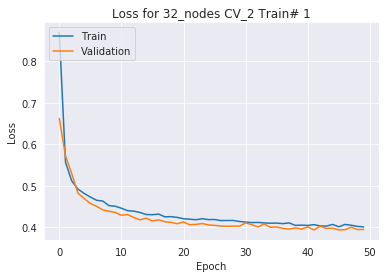

Test: tanh_1l_32
Recording time: 2019-12-11 08:06:14.366849
Duriation: 0:01:47.769797
-------------------------
cv_r2: 0.600420901965921
cv_mse: 0.39360360176196524
cv_rmse: 0.6273783561472018
-------------------------
train_r2: 0.603108167818922
train_mse: 0.39836369491280704
train_rmse: 0.6311605935994475



Epoch 00078: ReduceLROnPlateau reducing learning rate to 0.00010000000474974513.
Restoring model weights from the end of the best epoch.
Epoch 00079: early stopping


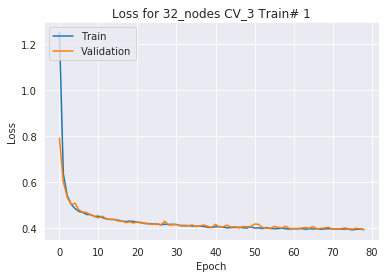

Test: tanh_1l_32
Recording time: 2019-12-11 08:06:31.121151
Duriation: 0:02:04.524872
-------------------------
cv_r2: 0.6126878519531219
cv_mse: 0.39328013764631264
cv_rmse: 0.627120512857228
-------------------------
train_r2: 0.6146845362672011
train_mse: 0.383831175416666
train_rmse: 0.6195411006677976



Epoch 00096: ReduceLROnPlateau reducing learning rate to 0.00010000000474974513.
Restoring model weights from the end of the best epoch.
Epoch 00097: early stopping


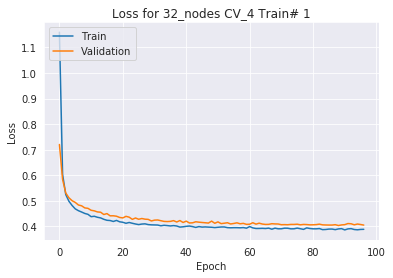

Test: tanh_1l_32
Recording time: 2019-12-11 08:06:51.167058
Duriation: 0:02:24.572448
-------------------------
cv_r2: 0.5958454156363686
cv_mse: 0.4036349905486097
cv_rmse: 0.6353227451843745
-------------------------
train_r2: 0.6203750568678881
train_mse: 0.37974598353823835
train_rmse: 0.6162353312966065



Epoch 00041: ReduceLROnPlateau reducing learning rate to 0.00010000000474974513.
Restoring model weights from the end of the best epoch.
Epoch 00042: early stopping


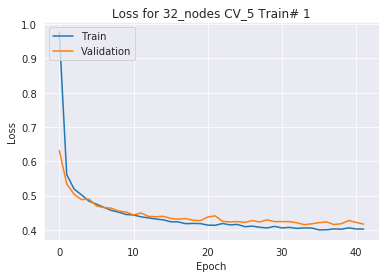

Test: tanh_1l_32
Recording time: 2019-12-11 08:07:02.290707
Duriation: 0:02:35.697019
-------------------------
cv_r2: 0.5822300366272514
cv_mse: 0.4151367276946621
cv_rmse: 0.6443110488689932
-------------------------
train_r2: 0.6059827684823935
train_mse: 0.39452668638792016
train_rmse: 0.6281135935385574


Training # 1
R2 (cross validation): 0.6004139960238069
RMSE (cross validation): 0.6319436576769426


R2 (cross validation): 1.1987648437821075
RMSE (cross validation): 1.2655449747620355


In [0]:
#@title Default title text
text_file_name = "20191212.txt"
retrain_times = ""

# Cross Validation
cross_validation = True
# Set to True if we want to train from scratch.  False will reuse saved models as a starting point.
retrain = True

numOfTraining = 1

from datetime import datetime

# If cv sets to True, applying cv training
if cross_validation:

  cv_score=[]
  cv_score_total=0
  epoch_n = 10000
  verbose = 0
  batch_size = 128

  loss_function = 'mean_squared_error'

  
  rmse_sum = []
  r2_sum = []

  for i in range(0,numOfTraining):
    start_time=datetime.now()

    for nodes in range(24, 33, 8):
      rmse_result = []
      r2_result = []
      cv_no = 0

      Kfold = KFold(n_splits=5, random_state=42, shuffle=True)
      Kfold_split = Kfold.split(np.arange(len(df_data)))

      for train_index, cv_index in Kfold_split:
        cv_no += 1

        train_input=input_data[train_index]
        cv_input=input_data[cv_index]

        train_target=target_data[train_index]
        cv_target=target_data[cv_index]


        # Loop through each molecule type
        !mkdir -p ~/kaggle/UCLA
        model_name_rd = ('/root/kaggle/UCLA/concrete_model_%s.hdf5' %cv_no)
        model_name_wrt = ('/root/kaggle/UCLA/concrete_model_%s.hdf5' %cv_no)

        # Build the Neural Net
        new_model = build_model()
        nn_model=new_model.create_nn_model(train_input.shape[1], nodes)

        # If retrain==False, then we load a previous saved model as a starting point.
        if not retrain:
            nn_model = load_model(model_name_rd)

        # compile
        #nn_model.compile(loss=loss_function, optimizer=Adam())#, metrics='rmse')
        nn_model.compile(optimizer = "rmsprop", loss = loss_function, metrics =["accuracy"])

        # Callback for Early Stopping... May want to raise the min_delta for small numbers of epochs
        es = callbacks.EarlyStopping(monitor='val_loss', min_delta=0.0000001, patience=8,verbose=1, mode='auto', restore_best_weights=True)
        # Callback for Reducing the Learning Rate... when the monitor levels out for 'patience' epochs, then the LR is reduced
        rlr = callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=7, min_lr=1e-6, mode='auto', verbose=1)
        # Save the best value of the model for future use
        sv_mod = callbacks.ModelCheckpoint(model_name_wrt, monitor='val_loss', save_best_only=True, period=1)

        history = nn_model.fit(train_input,train_target, 
                validation_data=(cv_input,cv_target), 
                callbacks=[es, rlr, sv_mod], epochs=epoch_n, batch_size=batch_size, verbose=verbose)
        
        cv_predict=nn_model.predict(cv_input)
        train_predict=nn_model.predict(train_input)
        plot_history(history,"%s_nodes CV_%s Train# %s" %(nodes, cv_no, i+1))

        end_time=datetime.now()
        processing_time = end_time - start_time
        # validation
        r2_v = r2_score(cv_target, cv_predict)
        mse_v = mean_squared_error(cv_target, cv_predict)
        rmse_v = math.sqrt(mse_v)
        # Training
        r2_t = r2_score(train_target, train_predict)
        mse_t = mean_squared_error(train_target, train_predict)
        rmse_t = math.sqrt(mse_t)

        test_name = "tanh_" + num_of_layers + "_" + str(nodes) + "_cv_" + str(cv_no)
        record =["Test: {}".format(test_name+retrain_times),
                "Recording time: {}".format(datetime.now()),
                "Duriation: {}".format(processing_time),
                "-------------------------",
                "cv_r2: {}".format(r2_v),
                "cv_mse: {}".format(mse_v),
                "cv_rmse: {}".format(rmse_v),
                "-------------------------",
                "train_r2: {}".format(r2_t),
                "train_mse: {}".format(mse_t),
                "train_rmse: {}".format(rmse_t),
                ]
        
        with open(r"/content/gdrive/My Drive/UCLA/_Lab/results/"+text_file_name, "a+") as file:
          for line in record:
            file.write(line + "\n")
            print(line)
          file.write("\n")
        print('\n')
        r2_result.append(r2_v)
        rmse_result.append(rmse_v)
        r2_sum.append(r2_v)
        rmse_sum.append(rmse_v)
  
      print("Training # %d" %(i+1))
      print("R2 (cross validation) mean: {} , STD: {}".format(sum(r2_result)/cv_no), std(r2_result))
      print("RMSE (cross validation): {}".format(sum(rmse_result)/cv_no), std(rmse_result))
      print('\n')
    
    retrain = False


  print("R2 (cross validation): {}".format(sum(r2_sum)/cv_no/numOfTraining))
  print("RMSE (cross validation): {}".format(sum(rmse_sum)/cv_no/numOfTraining))

In [0]:
#Validation function
n_folds = 5

def rmse_cv(model, train, y):
    estimator = KerasRegressor(build_fn = model.create_nn_model, epochs = 500, batch_size = 512, verbose = 0)
    kf = KFold(n_folds, shuffle=True, random_state=42).get_n_splits(train)#.values)
    rmse= np.sqrt(-cross_val_score(estimator, train, y, scoring="neg_mean_squared_error", cv = kf))
    return(rmse)

In [0]:
# evaluate model
# estimator = KerasRegressor(build_fn=baseline_model, epochs=100, batch_size=5, verbose=0)
# kfold = KFold(n_splits=5)
# results = cross_val_score(estimator, X, Y, cv=kfold)
# print("Baseline: %.2f (%.2f) MSE" % (results.mean(), results.std()))

In [0]:
# loss_function = 'mean_squared_error'

# input_model = build_model(train_input.shape[1])
# model = input_model.create_nn_model()
# model.compile(loss=loss_function, optimizer=Adam())
# #train_rmse = root_mean_squared_error(train_target, cv_predict[:,0])
# #train_r2 = r2_keras(train_target, cv_predict[:,0])

# #test_rmse = rmsle_cv(cv_target, cv_predict[:,0])
# #test_r2 = rmsle_cv(cv_target, cv_predict[:,0])

# test_rmse = rmse_cv(input_model, cv_input, cv_target)

# #print("RMSE of the training set: %".format(train_rmse))
# #print("R2 of the training set: %".format(train_r2))

# print("RMSE of the test set: %{0}  (%{1})".format(test_rmse.mean(),tset.rmse.std()))
# #print("R2 of the test set: %".format(test_r2))